# Density estimation
Use dataset

In [2]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import theano.tensor as tt
from theano import shared
import pandas as pd
import scipy as sp

## Load dataset
Peek into the data - curiosity helps build intuition
Intuition yields a prior (required for probabilistic modeling).


In [3]:
df = pd.read_csv('./pb/pb_asc_x1x5_x6.csv', header=None, names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df.head()

,x1,x2,x3,x4,x5,x6
0,16,30,41,48,53,16
1,1,26,41,50,57,11
2,23,33,42,46,59,4
3,2,18,19,22,63,19
4,10,16,40,52,55,17


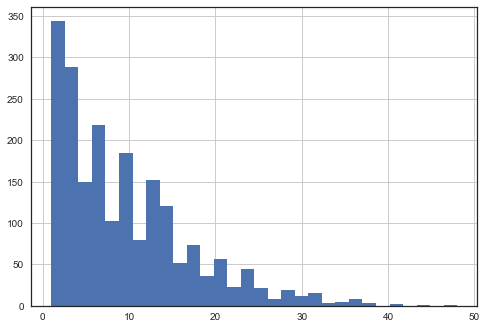

In [5]:
df['x1'].hist(bins=30)

### The Model
Assume x1 is given for x2, and so on
For x1, we estimate the density and pick the MAP 

In [6]:
%%latex
\begin{align}
\alpha \sim \Gamma(1,1) \\
\beta_1...\beta_K \sim \beta(1, \alpha) \\
w_i = \beta_i \prod_{j=1}^{i-1}(1-\beta_j) \\
a_i \sim U(0,50) \\
b_i \sim U(0,50) \\
\lambda_i = a_i * x_1 + b_i \\
x_2 \sim \sum_{}^{}w_i Pois(\lambda_i)\\
\end{align}

<IPython.core.display.Latex object>

In [7]:
SEED=5132290
K = 30
#x1 = df['x1'].values
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1-beta)[:-1]])
    return beta * portion_remaining


In [6]:

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    mu = pm.Uniform('mu', 0, 50, shape=K)
    bp = [pm.Bound(pm.Poisson, lower=1, upper=70).dist(mu=mu[i]) for i in range(K)] 
    x = pm.Mixture('obs', w, bp, observed=df['x1'].values)


In [7]:
with model:
    trace = pm.sample(1000, step=pm.Metropolis(), n_init=10000, random_seed=SEED)

100%|██████████| 1000/1000 [00:04<00:00, 208.98it/s]


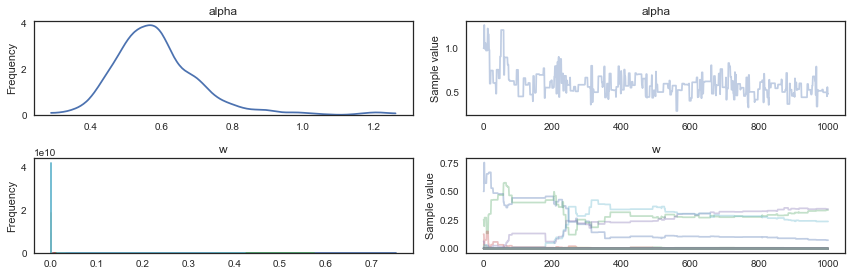

In [8]:
with model:
    pm.traceplot(trace, varnames=['alpha', 'w'])

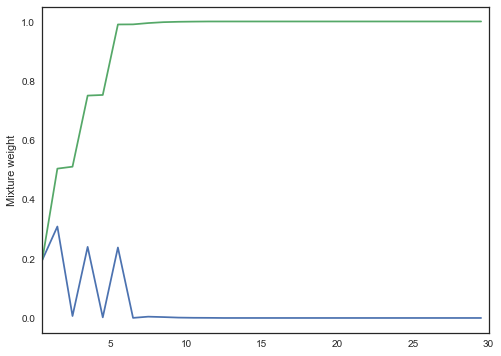

In [9]:
plot_w = np.arange(K) + 1
fig, ax = plt.subplots(figsize=(8,6))
#ax.hist(df['x2'].values, alpha=0.2, color='blue', normed=True)
ax.plot(plot_w-0.5, trace['w'].mean(axis=0) )
ax.plot(plot_w-0.5, np.cumsum(trace['w'].mean(axis=0)))
ax.set_xlim(.5, K)
ax.set_ylabel('Mixture weight')

In [10]:
np.cumsum(trace['w'].mean(axis=0))

array([ 0.1952044 ,  0.50368377,  0.51027047,  0.75003539,  0.75214244,
        0.98987932,  0.99019522,  0.99461279,  0.99763915,  0.99893057,
        0.99955439,  0.99997247,  0.99997922,  0.99999096,  0.9999912 ,
        0.99999265,  0.99999974,  0.99999998,  0.99999999,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

In [11]:
x_plot = np.arange(50) #Range of values of x1
#Create the set of Poisson distributions with means 'mu'
pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot), trace['mu'][:, np.newaxis, :])

#Multiply each distribution by its weight
wt_pmfs = (trace['w'][:, np.newaxis, :] * pmf_contribs).sum(axis=-1)
#trace['mu'].shape, x_plot.shape,np.atleast_3d(x_plot).shape, pmf_contribs.shape, pmfs.shape
wt_pmfs.shape, trace['mu'].shape, wt_pmfs[::200].shape, pmf_contribs.mean(axis=1).shape

((1000, 50), (1000, 30), (5, 50), (1000, 30))

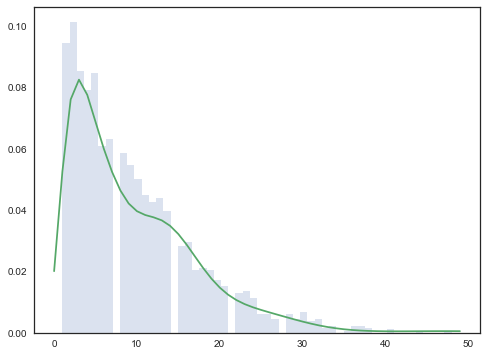

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df['x1'].values, bins=54, alpha=0.2,normed=True)
#ax.plot(x_plot, wt_pmfs[0])
ax.plot(x_plot, wt_pmfs.mean(axis=0))
#ax.plot(x_plot, wt_pmfs[::200].T, color='orange')

In [13]:
pmf_contribs.mean(axis=1).shape, wt_pmfs.mean(axis=1).shape, trace['mu'].shape

((1000, 30), (1000,), (1000, 30))

In [88]:
with model:
    ppc = pm.sample_ppc(trace, 2000)


100%|██████████| 2000/2000 [04:34<00:00,  6.62it/s]


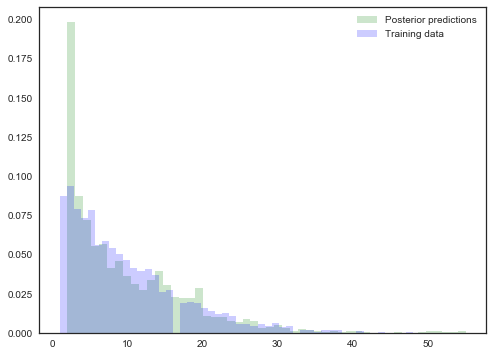

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(ppc['obs'], bins=50, normed=True, alpha=0.2, color='green', label='Posterior predictions')
ax.hist(df['x1'].values, bins=50, normed=True, alpha=0.2, color='blue', label='Training data')
ax.legend(loc=1)

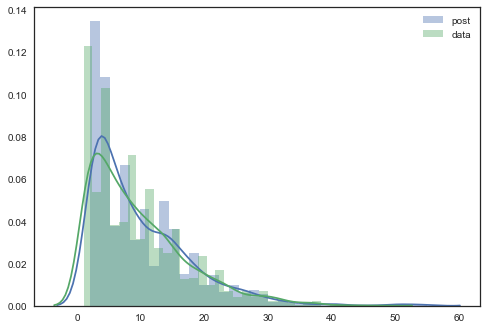

In [90]:
sns.distplot(ppc['obs'], label='post')
sns.distplot(df['x1'].values, label='data')
plt.legend(loc=1)

In [87]:
ppc['obs'].shape, df['x1'].shape

((1000,), (2022,))

### Try dependent distribution for x2
- Based on x1
- Refer to [pymc discussion](https://discourse.pymc.io/t/pm-sample-ppc-breaks-with-attributeerror/825/7)

In [6]:
#std_range = df.std_range.values[:, np.newaxis]
#shared(std_range, broadcastable=(False, True))
#x1_shift = ppc['obs'][:K]
x1_shift = shared(df['x1'].values[:, np.newaxis], broadcastable=(False, True))
x2obs = df['x2'].values[:, np.newaxis]
#x2obs = df['x2'].values

from pymc3.math import logsumexp
from pymc3.distributions.dist_math import bound

#Model for x2
with pm.Model() as x2model:
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    eta = pm.Uniform('eta', 0, 20, shape=K)
    delta = pm.Uniform('delta', 0, 5., shape=K)
    mu = pm.Deterministic('mu', eta + delta * x1_shift) 
    #Use a potential to add mixture logp to the model
    pm.Potential('logp', logsumexp(tt.log(w) + pm.Poisson.dist(mu).logp(x2obs), axis=-1).sum()
                )
    

In [45]:
with x2model:
    x2trace = pm.sample(500, n_init=5000, tune=500, random_seed=SEED)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -8,282.9: 100%|██████████| 5000/5000 [00:14<00:00, 337.92it/s]
Finished [100%]: Average ELBO = -8,206.6
100%|██████████| 500/500 [1:21:02<00:00,  2.58s/it]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123011128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11663c940>]], dtype=object)

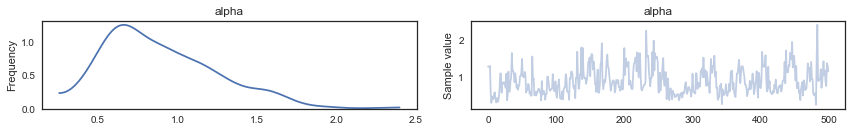

In [46]:
#df['x2'].values.shape, x2trace.varnames
pm.traceplot(x2trace, varnames=['alpha'])

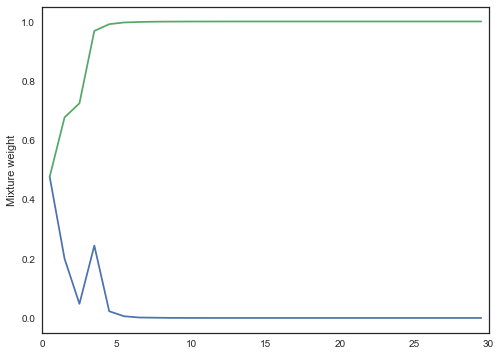

In [47]:
plot_x = np.arange(K) + 1
fig, ax = plt.subplots(figsize=(8,6))
#ax.hist(df['x2'].values, alpha=0.2, color='blue', normed=True)
ax.plot(plot_x-0.5, x2trace['w'].mean(axis=0), label='w')
ax.plot(plot_x-0.5, np.cumsum(x2trace['w'].mean(axis=0)))
#ax.plot(plot_x-0.5, x2trace['eta'].mean(axis=0), label='eta')
#ax.plot(plot_x-0.5, x2trace['delta'].mean(axis=0), label='delta')
ax.set_xlim(0, K)
ax.set_ylabel('Mixture weight')

In [48]:
# with x2model:
#     x2ppc = pm.sample_ppc(x2trace, 1000)
# A direct sample_ppc is not possible, so we have this contraption from
# @junpenglao at pymc_devs

from scipy.stats import poisson
wpost = x2trace['w']
mupost = x2trace['mu']
ndraws = wpost.shape[0]
nppc = 100
x2ppc = np.zeros((nppc, len(x2obs)))
for n in range(nppc):
    idx = np.random.randint(ndraws)
    pchoice = np.random.choice(K, len(x2obs), p=wpost[idx, :]/wpost[idx, :].sum())
#     mupost[mupost<=1] = 1
#     mupost[mupost>=70] = 70
    x2ppc[n, :] = poisson.rvs(mupost[idx, :, :])[range(len(x2obs)), pchoice]
x2ppc[x2ppc<1] = 1
x2ppc[x2ppc>70] = 70


In [49]:
mupost[0].max(), x2ppc[0].max(), x2ppc[10].max(), df['x2'].values.max(), mupost.shape, poisson.rvs(mupost[0,:,:]).shape,
poisson.rvs(mupost[0,:,:])[range(100)].shape, pchoice.shape, poisson.rvs([20, 10, 3]).shape, x2ppc.shape

((100, 30), (2022,), (3,), (100, 2022))

In [50]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.hist(mupost[0])
np.reshape(sp.stats.mode(x2ppc, axis=0)[0], (-1,1)).shape

(2022, 1)

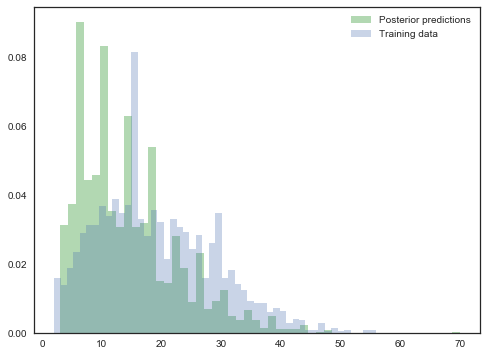

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.reshape(sp.stats.mode(x2ppc, axis=0)[0], (-1,1)), bins=50, normed=True, alpha=0.3, color='green', label='Posterior predictions')
#ax.hist(x2ppc[0], bins=50, normed=True, alpha=0.3, color='orange', label='x2ppc[0]')
#ax.hist(x2ppc[1], bins=50, normed=True, alpha=0.3, color='k', label='x2ppc[1]')
#ax.hist(x2ppc[2], bins=50, normed=True, alpha=0.3, color='k', label='x2ppc[2]')
ax.hist(df['x2'].values, bins=50, normed=True, alpha=0.3, label='Training data')
ax.legend(loc=1)

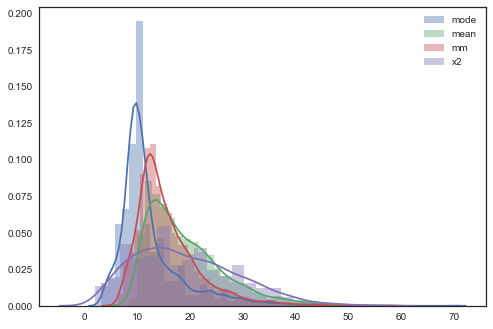

In [54]:

sns.distplot(np.reshape(sp.stats.mode(x2ppc, axis=0), (-1, 1)), label='mode')
sns.distplot(np.reshape(np.mean(x2ppc, axis=0), (-1, 1)), label='mean')
sns.distplot(np.reshape((sp.stats.mode(x2ppc, axis=0) + np.mean(x2ppc, axis=0) )/ 2., (-1, 1)), label='mm')
sns.distplot(df['x2'].values, label='x2')
plt.legend(loc=1)

### Trials and tribulations
A different way to produce x2

In [56]:
df['x1'].values.shape, df['x2'].values.shape

((2022,), (2022,))

In [1]:
#std_range = df.std_range.values[:, np.newaxis]
#shared(std_range, broadcastable=(False, True))
#x1_shift = ppc['obs'][:K]
x1_shift = shared(df['x1'].values[:, np.newaxis], broadcastable=(False, True))
#x2obs = df['x2'].values[:, np.newaxis]
x2obs = np.ndarray([23])

from pymc3.math import logsumexp
from pymc3.distributions.dist_math import bound

def norm_cdf(z):
    return 0.5 * (1 + tt.erf(z/np.sqrt(2)))

def rept_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[:, :1]), tt.extra_ops.cumprod(1 - v, axis=1)[:,:-1] ],
                             axis=1)
#Model for x2
with pm.Model() as x2model:
    x2alpha = pm.Gamma('x2alpha', 1, 1, shape=K)
    x2beta = pm.Beta('x2beta', 1, x2alpha, shape=K)
    x2w = pm.Deterministic('x2w', rept_breaking(norm_cdf(x2alpha + x2beta*x1_shift)))

    x2gamma = pm.HalfNormal('x2gamma', sd=10., shape=K)
    x2delta = pm.HalfNormal('x2delta', sd=10., shape=K)
    x2mu = pm.Deterministic('x2mu', x2gamma + x2delta*x1_shift)
    x2bp = [pm.Bound(pm.Poisson, lower=1, upper=70).dist(mu=x2mu[i]) for i in range(K)] 
    #x2bp = pm.Poisson('x2bp', mu=20, shape=K)
    pm.Mixture('x2obs', x2w, x2bp, observed=x2obs)
    


NameError: name 'shared' is not defined

In [17]:
x1_shift = shared(df['x1'].values[:, np.newaxis], broadcastable=(False, True))
#x1_shift = df['x1'].values[:, np.newaxis]
x2obs = df['x2'].values[:, np.newaxis]
K = 30
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1., shape=K)
    beta = pm.Gamma('beta', 1., 1., shape=K)
    
    gamma1 = pm.Uniform('gamma1', lower=1, upper=3, shape=K)
    gamma2 = pm.Uniform('gamma2', lower=-1, upper=1, shape=K)
    gamma3 = pm.Uniform('gamma3', lower=-1, upper=1, shape=K)
    
    shmu = pm.Deterministic('shmu', gamma1*x1_shift ) #+ gamma2*alpha*np.sqrt(x1_shift) + gamma3*beta*np.log(x1_shift))

    delta = pm.Gamma('delta', 1., 1., shape=K)
    
    #mixture components
    components = pm.NegativeBinomial.dist(mu=shmu, alpha=delta, shape=K)
    
    #mixture component weights
    w = pm.Dirichlet('w', a=np.array([1]*K)) 
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=x2obs)


In [18]:
theano.config.exception_verbosity='high'
theano.config.mode='DebugMode'
with model:
    x2trace = pm.sample(100, n_init=1000)
    pm.sample_ppc(x2trace, 10)
    x2ppc = pm.traceplot(x2trace, varnames=['w', 'shmu'])
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...





  0%|          | 0/1000 [00:00<?, ?it/s]

InvalidValueError: InvalidValueError
        type(variable) = TensorType(float32, scalar)
        variable       = TensorConstant{-inf}
        type(value)    = <class 'numpy.ndarray'>
        dtype(value)   = float32
        shape(value)   = ()
        value          = -inf
        min(value)     = -inf
        max(value)     = -inf
        isfinite       = False
        client_node    = None
        hint           = Graph Input 'TensorConstant{-inf}' has invalid value -inf
        specific_hint  = none
        context        = ...
  TensorConstant{-inf} [id A]

        

In [ ]:
sns.distplot(x2obs, label='observed')
sns.distplot(x2ppc['like'], label='x2ppc')
plt.legend(loc=1)

In [ ]:
with x2model:
    x2trace = pm.sample(10, n_init=10000, random_seed=SEED)
    pm.traceplot(x2trace, varnames=['x2alpha', 'x2w'])

In [ ]:
plot_w = np.arange(K) + 1
fig, ax = plt.subplots(figsize=(8,6))
#ax.hist(df['x2'].values, alpha=0.2, color='blue', normed=True)
ax.plot(plot_w-0.5, x2trace['w'].mean(axis=0) )
ax.plot(plot_w-0.5, np.cumsum(x2trace['w'].mean(axis=0)))
ax.set_xlim(.5, K)
ax.set_ylabel('Mixture weight')